# Data Frame Creation

In [108]:
import pandas as pd

# Specify the file names
file_names = ["prices_round_4_day_1.csv", "prices_round_4_day_2.csv", "prices_round_4_day_3.csv"]

# Initialize dictionaries to store DataFrames for each product and each day
dfs_coconut = {day: {} for day in range(1, 4)}
dfs_coconut_coupon = {day: {} for day in range(1, 4)}

# Iterate through the file names
for day, file_name in enumerate(file_names, start=1):
    # Read CSV file with semicolon delimiter
    df = pd.read_csv(file_name, delimiter=';')
    
    # Separate data for each product
    for product in ["COCONUT", "COCONUT_COUPON"]:
        # Filter data for the current product
        df_product = df[df["product"] == product][["day", "timestamp","product", "mid_price"]]
        
        # Reset index and store in the respective dictionary
        df_product.reset_index(drop=True, inplace=True)
        
        # Add a column for 'price_diff' if the product is 'COCONUT_COUPON'
        if product == "COCONUT_COUPON":
            # Retrieve the current price of coconut (strike price is 10000)
            coconut_price = dfs_coconut[day]["mid_price"]
            df_product["curr_price"] = coconut_price
        
        # Store the DataFrame in the respective dictionary
        if product == "COCONUT":
            dfs_coconut[day] = df_product
        elif product == "COCONUT_COUPON":
            dfs_coconut_coupon[day] = df_product

In [115]:
import pandas as pd

# Specify the file names
file_names = ["prices_round_4_day_1.csv", "prices_round_4_day_2.csv", "prices_round_4_day_3.csv"]

# Initialize an empty list to store DataFrames
dfs = []

# Iterate through the file names
for file_name in file_names:
    # Read each CSV file with semicolon delimiter and append it to the list of DataFrames
    df = pd.read_csv(file_name, delimiter=';')
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)

# Check the columns of the consolidated DataFrame
print(data.columns)

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss'],
      dtype='object')


In [117]:
import pandas as pd


# Separate the data into individual DataFrames for each product
products = ["COCONUT", "COCONUT_COUPON"]
dfs = {}
for product in products:
    df_product = data[data["product"] == product][["product", "mid_price"]]
    df_product.reset_index(drop=True, inplace=True)
    dfs[product] = df_product

# Options Strategy

In [110]:
# Define the delta calculation function
import numpy as np
from scipy.stats import norm
from statistics import NormalDist

r = 0
S = 9998.5
K = 10000
max_time = 250 * 1000000
day = 1000000
sigma = 0.15996795309342315
differences = []
def blackScholes(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
    return price

# Iterate through each day's DataFrame in dfs_coconut_coupon
for day, df_coconut_coupon in dfs_coconut_coupon.items():
    # Calculate time to expiration (T) for each row
    timestamp = df_coconut_coupon["timestamp"]
    curr_day = df_coconut_coupon["day"] - 1
    curr_timestamp = (curr_day * day) + timestamp
    T = (max_time - curr_timestamp)/ max_time
    S = df_coconut_coupon["curr_price"]
    delta = blackScholes(r, S, K, T, sigma)
    # Calculate delta for each row using the delta_calc function
    df_coconut_coupon["delta"] = delta
    difference = abs(df_coconut_coupon["delta"] - df_coconut_coupon["mid_price"])
    differences.append(difference)

In [111]:
r = 0
S = 9998.5
K = 10000
max_time = 250 * 1000000
day = 1000000
sigma = 0.15996795309342315
T = 1
def blackScholes(r, S, K, T, sigma):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    price = S*NormalDist(mu=0, sigma=1).cdf(d1) - K*np.exp(-r*T)*NormalDist(mu=0, sigma=1).cdf(d2)
    return price
out = blackScholes(r, S, K, T, sigma)

636.702467187436


In [112]:
all_differences = pd.concat(differences)

# Compute summary statistics for the differences
stats = all_differences.describe()
print(stats)

{1:       day  timestamp         product  mid_price  curr_price       delta
0       1          0  COCONUT_COUPON      637.5     10000.0  637.500000
1       1        100  COCONUT_COUPON      637.5      9999.5  637.233966
2       1        200  COCONUT_COUPON      637.5      9998.5  636.702213
3       1        300  COCONUT_COUPON      638.5      9999.5  637.233712
4       1        400  COCONUT_COUPON      637.5      9998.5  636.701958
...   ...        ...             ...        ...         ...         ...
9995    1     999500  COCONUT_COUPON      681.5     10135.5  710.557517
9996    1     999600  COCONUT_COUPON      682.5     10136.5  711.122696
9997    1     999700  COCONUT_COUPON      681.5     10134.5  709.992198
9998    1     999800  COCONUT_COUPON      681.5     10135.0  710.274571
9999    1     999900  COCONUT_COUPON      682.5     10135.0  710.274443

[10000 rows x 6 columns], 2:       day  timestamp         product  mid_price  curr_price       delta
0       2          0  COCONUT_

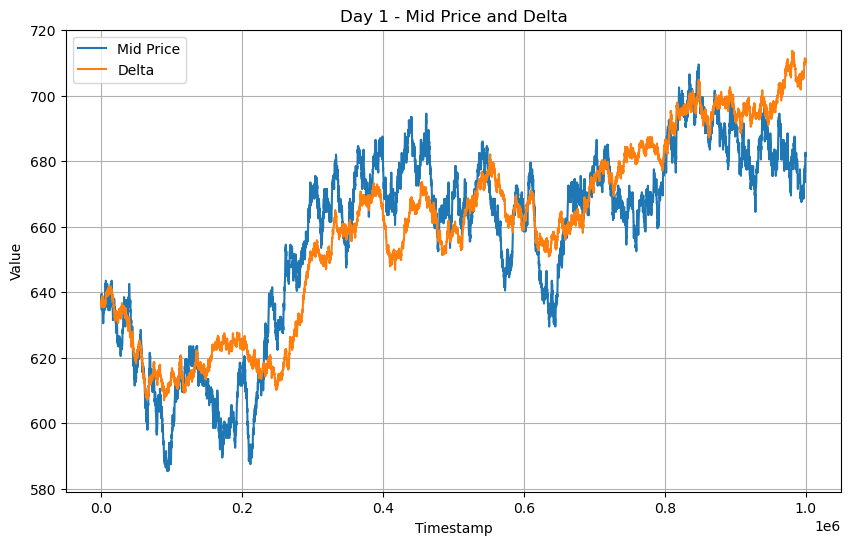

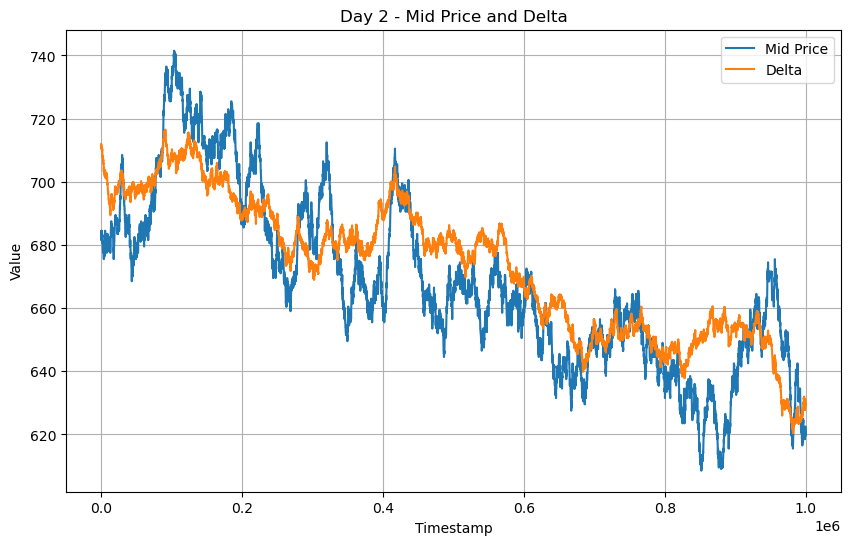

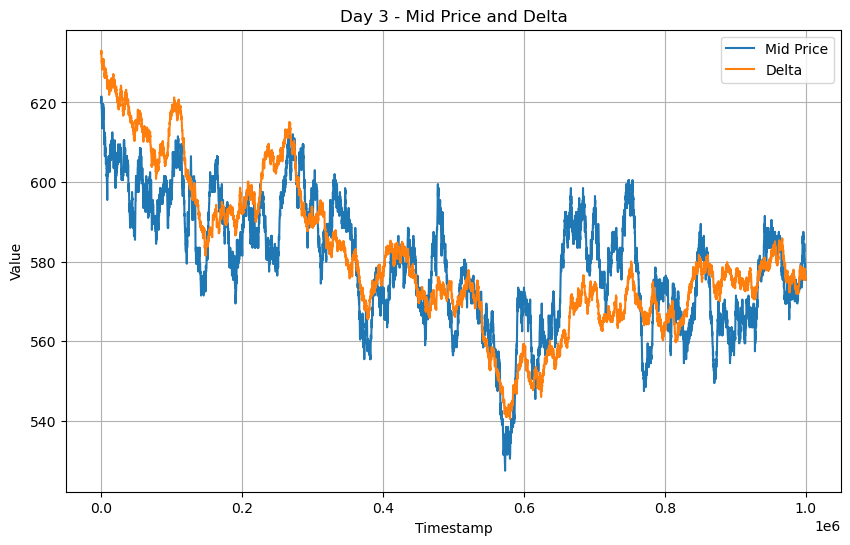

In [113]:
import matplotlib.pyplot as plt

# Plot mid_price and delta for each day
for day, df_coconut_coupon in dfs_coconut_coupon.items():
    plt.figure(figsize=(10, 6))
    
    # Plot mid_price
    plt.plot(df_coconut_coupon['timestamp'], df_coconut_coupon['mid_price'], label='Mid Price')
    
    # Plot delta
    plt.plot(df_coconut_coupon['timestamp'], df_coconut_coupon['delta'], label='Delta')
    
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(f'Day {day} - Mid Price and Delta')
    plt.legend()
    plt.grid(True)
    plt.show()

# Coconuts Strategy

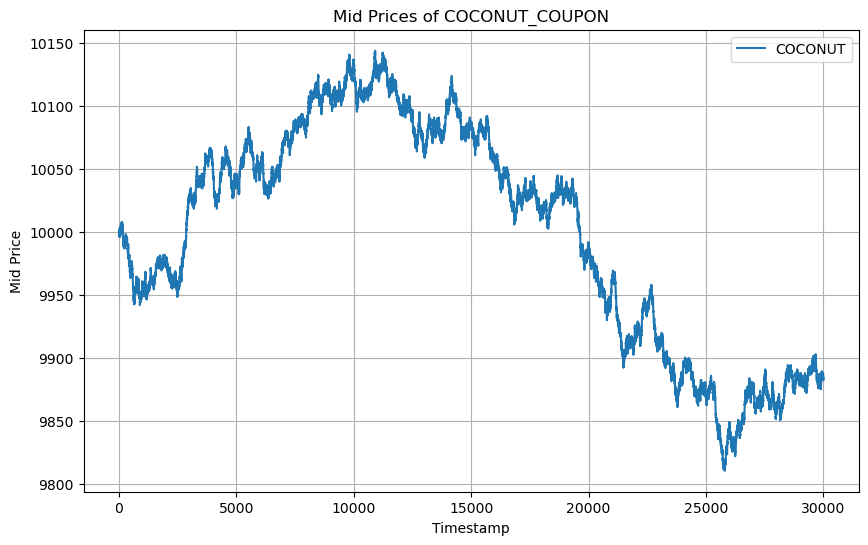

In [123]:
import matplotlib.pyplot as plt

# Plotting COCONUT mid_prices
plt.figure(figsize=(10, 6))
plt.plot(dfs["COCONUT"]["mid_price"], label="COCONUT")

# Adding labels and title
plt.xlabel("Timestamp")
plt.ylabel("Mid Price")
plt.title("Mid Prices of COCONUT_COUPON")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [119]:
coconut_df = dfs["COCONUT"]
stats = coconut_df["mid_price"].describe()
print(stats)

count    30000.000000
mean      9999.900983
std         88.754144
min       9810.500000
25%       9913.500000
50%      10026.000000
75%      10077.500000
max      10144.000000
Name: mid_price, dtype: float64


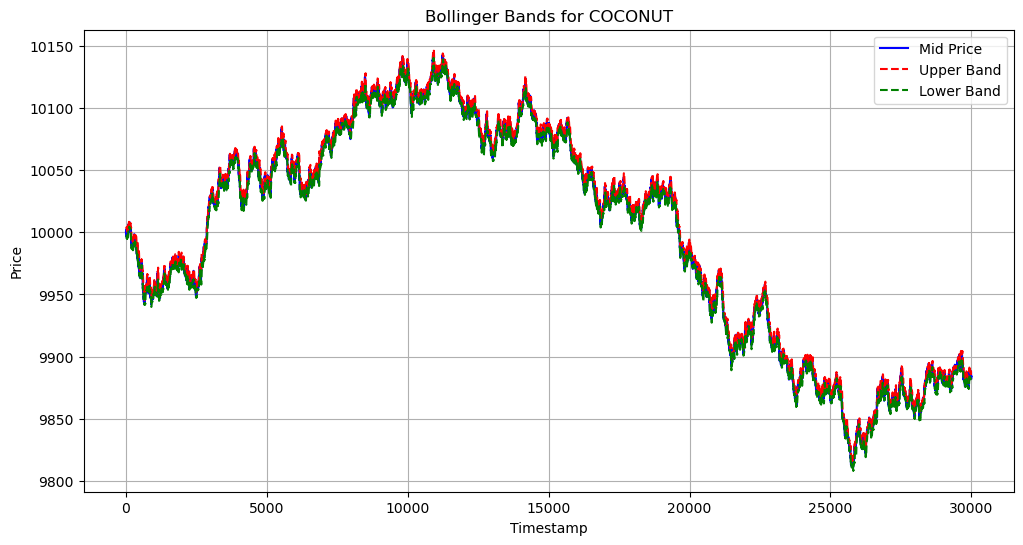

In [122]:
import matplotlib.pyplot as plt

# Define window size for rolling calculations
window = 20


# Calculate rolling mean and rolling standard deviation
coconut_df['rolling_mean'] = coconut_df['mid_price'].rolling(window=window).mean()
coconut_df['rolling_std'] = coconut_df['mid_price'].rolling(window=window).std()

# Calculate upper and lower Bollinger Bands
coconut_df['upper_band'] = coconut_df['rolling_mean'] + 2 * coconut_df['rolling_std']
coconut_df['lower_band'] = coconut_df['rolling_mean'] - 2 * coconut_df['rolling_std']

# Plot mid_price and Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(coconut_df['mid_price'], label='Mid Price', color='blue')
plt.plot(coconut_df['upper_band'], label='Upper Band', color='red', linestyle='--')
plt.plot(coconut_df['lower_band'], label='Lower Band', color='green', linestyle='--')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Bollinger Bands for COCONUT')
plt.legend()
plt.grid(True)
plt.show()

In [159]:
# Describe statistics for COCONUT
coconut_stats = dfs["COCONUT"]["mid_price"].describe()
print("Statistics for COCONUT:")
print(coconut_stats)

# Describe statistics for COCONUT_COUPON
coconut_coupon_stats = dfs["COCONUT_COUPON"]["mid_price"].describe()
print("\nStatistics for COCONUT_COUPON:")
print(coconut_coupon_stats)

Statistics for COCONUT:
count    30000.000000
mean      9999.900983
std         88.754144
min       9810.500000
25%       9913.500000
50%      10026.000000
75%      10077.500000
max      10144.000000
Name: mid_price, dtype: float64

Statistics for COCONUT_COUPON:
count    30000.000000
mean       635.046433
std         46.593951
min        527.500000
25%        590.500000
50%        645.500000
75%        671.500000
max        741.500000
Name: mid_price, dtype: float64


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define a range of window sizes to test
window_sizes = range(1, 10)  # Test window sizes from 1 to 20

# Initialize variables to store results
results = []

# Iterate over window sizes
for window_size in window_sizes:
    # Create a dataframe with window_size columns containing the previous prices
    df = pd.DataFrame()
    for i in range(window_size):
        df[f'last_price_{i+1}'] = starfruit_df['mid_price'].shift(i+1)
    df['mid_price'] = starfruit_df['mid_price']  # Add the target variable

    # Drop rows with NaN values (due to shifting)
    df.dropna(inplace=True)

    # Prepare the data
    X = df.drop('mid_price', axis=1)
    y = df['mid_price']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    
    intercept = model.intercept_
    coefficients = model.coef_
    print("Intercept:", intercept)
    print("Coefficient:", coefficients)
    equation = f"y = {intercept}"
    for i, coef in enumerate(coefficients):
        equation += f" + ({coef} * last_price_{i+1})"
    print("Equation:", equation)


    # Store the results
    results.append((window_size, train_rmse, test_rmse))

# Initialize variables to store the optimal window size and corresponding test RMSE
optimal_window_size = None
min_test_rmse = float('inf')

# Iterate over the results to find the optimal window size
for window_size, train_rmse, test_rmse in results:
    print("Window Size:", window_size)
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print()

    # Update the optimal window size if the current test RMSE is lower
    if test_rmse < min_test_rmse:
        optimal_window_size = window_size
        min_test_rmse = test_rmse

# Print the optimal window size and corresponding test RMSE
print("Optimal Window Size:", optimal_window_size)
print("Corresponding Test RMSE:", min_test_rmse)

In [44]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve

def black_scholes_d1(S, K, r, T, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

def black_scholes_d2(S, K, r, T, sigma):
    return black_scholes_d1(S, K, r, T, sigma) - sigma * np.sqrt(T)

def black_scholes_call(S, K, r, T, sigma):
    d1 = black_scholes_d1(S, K, r, T, sigma)
    d2 = black_scholes_d2(S, K, r, T, sigma)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def option_price_error(sigma, option_price, S, K, r, T):
    return black_scholes_call(S, K, r, T, sigma) - option_price

# Given parameters
r = 0  # Risk-free interest rate
S = 10000.0   # Current price of the underlying asset
K = 10000.0   # Strike price of the option
T = 1    
option_price = 637.5  # Option price (change this to the desired price)

# Solve for sigma numerically
initial_guess_sigma = 0.3  # Initial guess for sigma
sigma_solution = fsolve(option_price_error, initial_guess_sigma, args=(option_price, S, K, r, T))[0]
print("Estimated volatility (sigma):", sigma_solution)


Estimated volatility (sigma): 0.15996795309342315


In [47]:
r = 0
S = 9998.5
K = 10000
T = ((250 * 1000000) - 400)/(250 * 1000000)
sigma = 0.15996795309342315
def blackScholes(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
    return price
print("Option Price: ", blackScholes(r, S, K, T, sigma, "c"))

Option Price:  636.701958312261


# Total Profit

In [92]:
import csv

# input_file = 'v2_success.log'
input_file = 'round4.log'
output_file = 'round4.csv'

# Set to True when inside the Activities log section
inside_activities_log = False

# Define the headers for the CSV file
headers = ['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2',
           'bid_price_3', 'bid_volume_3', 'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
           'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss']
count = 0

# Open the input log file and output CSV file
with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
    # Create a CSV writer object
    writer = csv.writer(outfile)
    
    # Write the headers to the CSV file
    writer.writerow(headers)
    
    # Read each line from the log file
    for line in infile:
        # Check if the line contains the start of the "Activities log" section
        if line.strip() == "Activities log:":
            inside_activities_log = True
            continue
        
        # Check if the line contains the end of the "Activities log" section
        elif line.strip() == "Trade History:" or line.strip() == "Sandbox logs:":
            inside_activities_log = False
            continue
        
        # Skip over empty lines
        elif not line.strip():
            continue
        
        # If inside the "Activities log" section, write the line to the CSV file
        elif inside_activities_log:
            if count > 0:
                # Split the line into fields based on the delimiter (;)
                fields = line.strip().split(';')

                # Write the fields to the CSV file
                writer.writerow(fields)
            count += 1

print("CSV file created successfully.")

CSV file created successfully.


In [93]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('round4.csv')

# Get unique product names
unique_products = df['product'].unique()

# Create an empty dictionary to store DataFrames for each product
product_dfs = {}

# Iterate over unique product names
for product in unique_products:
    # Filter the original DataFrame for the current product
    product_df = df[df['product'] == product].copy()
    # Reset index to avoid any index conflicts
    product_df.reset_index(drop=True, inplace=True)
    # Store the DataFrame in the dictionary with the product name as key
    product_dfs[product] = product_df

# Access DataFrames for individual products using their names
amethysts_df = product_dfs['AMETHYSTS']
starfruit_df = product_dfs['STARFRUIT']
orchids_df = product_dfs['ORCHIDS']
baskets_df = product_dfs['GIFT_BASKET']
coconut_coupons_df = product_dfs['COCONUT_COUPON']

In [94]:
# Calculate total profit for each commodity
total_profit_amethysts = amethysts_df['profit_and_loss'].sum()
total_profit_starfruit = starfruit_df['profit_and_loss'].sum()
total_profit_orchids = orchids_df['profit_and_loss'].sum()
total_profit_baskets = baskets_df['profit_and_loss'].sum()
total_profit_coconut_coupons = coconut_coupons_df['profit_and_loss'].sum()

# Calculate total profit
total_profit = total_profit_amethysts + total_profit_starfruit + total_profit_orchids + total_profit_baskets + total_profit_coconut_coupons

print("Total profit for Amethysts:", total_profit_amethysts)
print("Total profit for Starfruit:", total_profit_starfruit)
print("Total profit for Orchids:", total_profit_orchids)
print("Total profit for Baskets:", total_profit_baskets)
print("Total profit for Coconut Coupons: ", total_profit_coconut_coupons)
print("Total profit for all commodities:", total_profit)

Total profit for Amethysts: 875260.0
Total profit for Starfruit: 778073.4682617188
Total profit for Orchids: 3165496.259033203
Total profit for Baskets: 0.0
Total profit for Coconut Coupons:  10746301.33203125
Total profit for all commodities: 15565131.059326172


# Manual Trading

Distribution:  {900: 1, 901: 2, 902: 3, 903: 4, 904: 5, 905: 6, 906: 7, 907: 8, 908: 9, 909: 10, 910: 11, 911: 12, 912: 13, 913: 14, 914: 15, 915: 16, 916: 17, 917: 18, 918: 19, 919: 20, 920: 21, 921: 22, 922: 23, 923: 24, 924: 25, 925: 26, 926: 27, 927: 28, 928: 29, 929: 30, 930: 31, 931: 32, 932: 33, 933: 34, 934: 35, 935: 36, 936: 37, 937: 38, 938: 39, 939: 40, 940: 41, 941: 42, 942: 43, 943: 44, 944: 45, 945: 46, 946: 47, 947: 48, 948: 49, 949: 50, 950: 51, 951: 52, 952: 53, 953: 54, 954: 55, 955: 56, 956: 57, 957: 58, 958: 59, 959: 60, 960: 61, 961: 62, 962: 63, 963: 64, 964: 65, 965: 66, 966: 67, 967: 68, 968: 69, 969: 70, 970: 71, 971: 72, 972: 73, 973: 74, 974: 75, 975: 76, 976: 77, 977: 78, 978: 79, 979: 80, 980: 81, 981: 82, 982: 83, 983: 84, 984: 85, 985: 86, 986: 87, 987: 88, 988: 89, 989: 90, 990: 91, 991: 92, 992: 93, 993: 94, 994: 95, 995: 96, 996: 97, 997: 98, 998: 99, 999: 100, 1000: 101}
Optimal Low Bid: 939
Optimal High Bid: 980
Max Profit: 3260


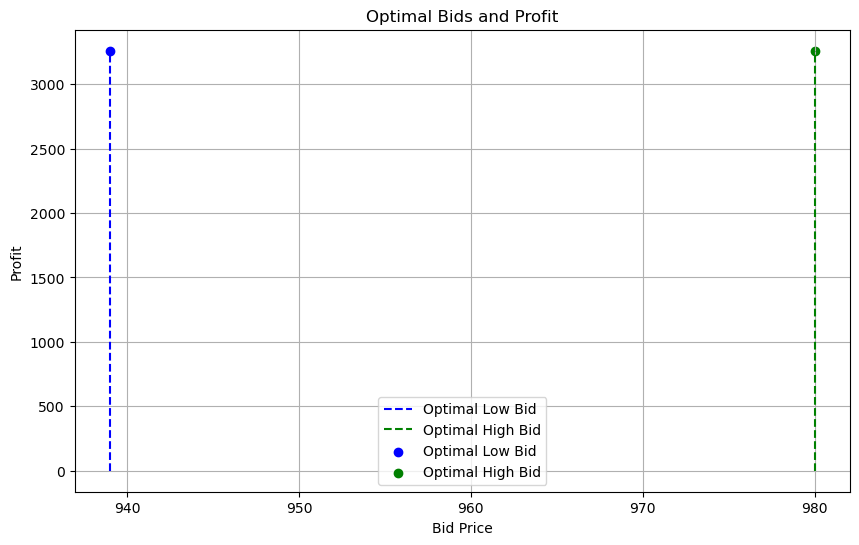

In [129]:
import matplotlib.pyplot as plt

def calculate_profit(low_bid, high_bid, distribution, average_bid):
    # Calculate the scaling factor p
    p = (1000 - average_bid) / (1000 - high_bid)
    
    # Initialize profit
    profit = 0
    
    # Calculate profit based on whether the second bid is above or below the average bid
    if high_bid >= average_bid:
        profit = distribution[low_bid] * (1000 - low_bid) + (distribution[high_bid] - distribution[low_bid]) * (1000 - high_bid)
    else:
        profit = p * (1000 - high_bid) + (distribution[low_bid] * (1000 - low_bid))
    
    return profit

def create_probability_distribution(lower_bound, upper_bound):
    distribution = {}
    for bid in range(lower_bound, upper_bound + 1):
        # Calculate the number of goldfish willing to purchase
        # This is assumed to increase linearly from 1 to the number of bids
        num_goldfish = bid - lower_bound + 1
        distribution[bid] = num_goldfish
    return distribution

def find_optimal_bids(distribution, average_bid):
    max_profit = 0
    optimal_low_bid = 900
    optimal_high_bid = 900
    
    for low_bid in range(900, 1001):
        for high_bid in range(low_bid + 1, 1000):
            profit = calculate_profit(low_bid, high_bid, distribution, average_bid)
            if profit > max_profit:
                max_profit = profit
                optimal_low_bid = low_bid
                optimal_high_bid = high_bid
    
    return optimal_low_bid, optimal_high_bid, max_profit

def plot_results(optimal_low_bid, optimal_high_bid, max_profit):
    plt.figure(figsize=(10, 6))
    plt.plot([optimal_low_bid, optimal_low_bid], [0, max_profit], color='blue', linestyle='--', label='Optimal Low Bid')
    plt.plot([optimal_high_bid, optimal_high_bid], [0, max_profit], color='green', linestyle='--', label='Optimal High Bid')
    plt.scatter(optimal_low_bid, max_profit, color='blue', marker='o', label='Optimal Low Bid')
    plt.scatter(optimal_high_bid, max_profit, color='green', marker='o', label='Optimal High Bid')
    plt.xlabel('Bid Price')
    plt.ylabel('Profit')
    plt.title('Optimal Bids and Profit')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
lower_bound = 900
upper_bound = 1000
distribution = create_probability_distribution(lower_bound, upper_bound)
average_bid = 980  # Assume an average bid of 950 for illustration purposes
optimal_low_bid, optimal_high_bid, max_profit = find_optimal_bids(distribution, average_bid)
print("Distribution: ", distribution)
print("Optimal Low Bid:", optimal_low_bid)
print("Optimal High Bid:", optimal_high_bid)
print("Max Profit:", max_profit)

plot_results(optimal_low_bid, optimal_high_bid, max_profit)

[ 900  901  902  903  904  905  906  907  908  909  910  911  912  913
  914  915  916  917  918  919  920  921  922  923  924  925  926  927
  928  929  930  931  932  933  934  935  936  937  938  939  940  941
  942  943  944  945  946  947  948  949  950  951  952  953  954  955
  956  957  958  959  960  961  962  963  964  965  966  967  968  969
  970  971  972  973  974  975  976  977  978  979  980  981  982  983
  984  985  986  987  988  989  990  991  992  993  994  995  996  997
  998  999 1000]
[0.     0.0002 0.0004 0.0006 0.0008 0.001  0.0012 0.0014 0.0016 0.0018
 0.002  0.0022 0.0024 0.0026 0.0028 0.003  0.0032 0.0034 0.0036 0.0038
 0.004  0.0042 0.0044 0.0046 0.0048 0.005  0.0052 0.0054 0.0056 0.0058
 0.006  0.0062 0.0064 0.0066 0.0068 0.007  0.0072 0.0074 0.0076 0.0078
 0.008  0.0082 0.0084 0.0086 0.0088 0.009  0.0092 0.0094 0.0096 0.0098
 0.01   0.0102 0.0104 0.0106 0.0108 0.011  0.0112 0.0114 0.0116 0.0118
 0.012  0.0122 0.0124 0.0126 0.0128 0.013  0.0132 0.0134 0.0

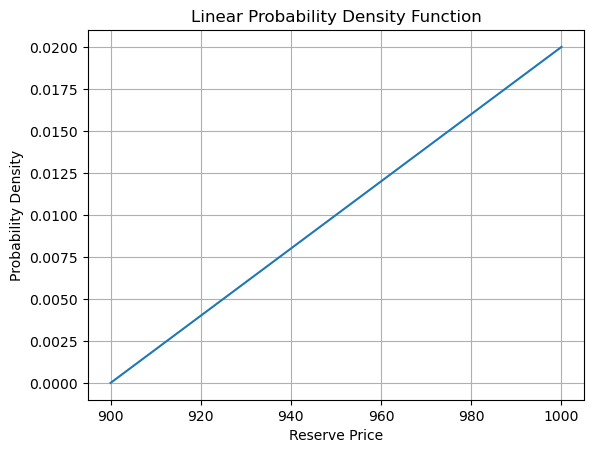

In [126]:
import numpy as np
import matplotlib.pyplot as plt

def linear_pdf(x):
    # Define the range of reserve prices
    lower_bound = 900
    upper_bound = 1000
    
    # Calculate slope and intercept for the linear function
    slope = float(1 / (upper_bound - lower_bound))
    intercept = -slope * lower_bound
    
    # Linear PDF function
    pdf = slope * x + intercept
    
    # Normalize the PDF
    normalization_constant = np.trapz(pdf, x)
    pdf /= normalization_constant
    
    return pdf

# Generate x values from 900 to 1000
x_values = np.arange(900, 1001)

# Calculate the PDF values
pdf_values = linear_pdf(x_values)
print(x_values)
print(pdf_values, sum(pdf_values))
# Plot the distribution
plt.plot(x_values, pdf_values)
plt.xlabel('Reserve Price')
plt.ylabel('Probability Density')
plt.title('Linear Probability Density Function')
plt.grid(True)
plt.show()

{900: 0.0, 901: 0.00019999999999999565, 902: 0.0003999999999999913, 903: 0.0005999999999999869, 904: 0.0008000000000000181, 905: 0.0010000000000000137, 906: 0.0012000000000000094, 907: 0.0014000000000000052, 908: 0.0016000000000000007, 909: 0.0017999999999999965, 910: 0.0019999999999999922, 911: 0.0021999999999999876, 912: 0.002400000000000019, 913: 0.0026000000000000146, 914: 0.0028000000000000104, 915: 0.0030000000000000057, 916: 0.0032000000000000015, 917: 0.003399999999999997, 918: 0.003599999999999993, 919: 0.0037999999999999883, 920: 0.00400000000000002, 921: 0.004200000000000015, 922: 0.004400000000000011, 923: 0.004600000000000007, 924: 0.004800000000000002, 925: 0.0049999999999999975, 926: 0.005199999999999994, 927: 0.005399999999999989, 928: 0.005599999999999985, 929: 0.005800000000000016, 930: 0.006000000000000011, 931: 0.006200000000000008, 932: 0.006400000000000003, 933: 0.006599999999999998, 934: 0.006799999999999994, 935: 0.00699999999999999, 936: 0.007199999999999986, 9

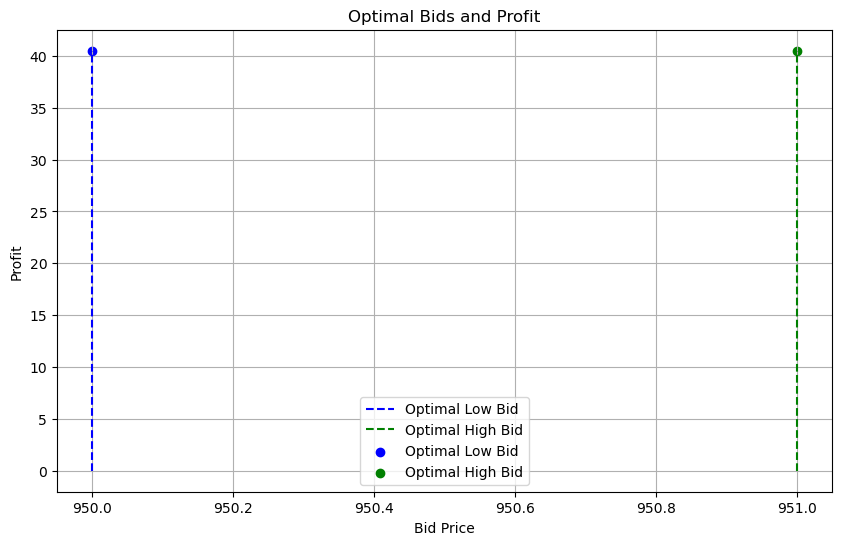

In [131]:
linear_pdf_dict = dict(zip(x_values, pdf_values))
print(linear_pdf_dict)
lower_bound = 900
upper_bound = 1000
distribution = create_probability_distribution(lower_bound, upper_bound)
optimal_low_bid, optimal_high_bid, max_profit = find_optimal_bids(linear_pdf_dict, 960)
print("Optimal Low Bid:", optimal_low_bid)
print("Optimal High Bid:", optimal_high_bid)
print("Max Profit:", max_profit)

plot_results(optimal_low_bid, optimal_high_bid, max_profit)